### Import librar and declare variables

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import requests
import urllib
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

In [4]:
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
input_size = 128
batch_size = 16
img_size = (input_size, input_size)

In [7]:
# tf.test.gpu_device_name()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Prepearing data

In [8]:
# Enumerates image files from given root folder
def image_file_iterator(root):
    for subdir, dirs, files in os.walk(root):        
        for file in files:
            if (file.endswith('.png')):
                yield os.path.join(subdir, file)

In [9]:
def GetPexelPhotos():
    api_key = "api_key"
    # directory = "/content/drive/MyDrive/projects/Pexel_photos/Faces/"
    directory = "../datasets/Pexel_photos/Faces/"
    list_directory = os.listdir(directory)
    if len(directory) == 0:
        Headers = {"Authorization": api_key}
        # Downloading files from API if the folder is empty
        res = requests.get(
            "https://api.pexels.com/v1/search?query=humansface&orientation=portrait&per_page=80&src=original", headers=Headers)
        if res:
            while True:
                json_file = res.json()
                if 'photos' in json_file:
                    photos = json_file['photos']
                    for photo in photos:
                        ac = photo['avg_color']
                        if (ac[1] == ac[3] == ac[5] and ac[2] == ac[4] == ac[6]) \
                                or photo['alt'].lower().find('grayscale') >= 0 \
                                or photo['url'].lower().find('grayscale') >= 0:  # All grayscale images Hex colormap is like #XYXYXY, example - #797979
                            continue  # We don't need grayscale photo
                        original = photo['src']['original']
                        link = original+'?auto=compress&cs=tinysrgb&fit=crop&h=' + \
                            str(input_size)+'&w='+str(input_size)+''
                        photo_name = original.split('/')[-1]

                        page = requests.get(link)
                        with open(directory+photo_name, 'wb') as f:
                            f.write(page.content)  # Saving photo

                    if 'next_page' in json_file:
                        next_page = json_file['next_page']
                        res = requests.get(next_page, headers=Headers)
                        if res:
                            continue

                break

    input_img_paths = [f for f in os.listdir(directory) if f.endswith(
        ".jpg") or f.endswith(".jpeg") or f.endswith(".png")]
    input_img_paths = sorted([os.path.join(directory, fname)
                             for fname in input_img_paths])
    return input_img_paths

In [10]:
dataset = 'colorizer'

if dataset == 'pexel':
    input_img_paths = GetPexelPhotos()
    split_test = 0.1
    train_files_list = input_img_paths[:-round(len(input_img_paths)*split_test)]
    test_files_list = input_img_paths[-round(len(input_img_paths)*split_test):]
else:
    directory = "../datasets/Colorizer_dataset/"
    train_dir = os.path.join(directory, "train")
    test_dir = os.path.join(directory, "test")
    train_files_list = list(image_file_iterator(train_dir))
    test_files_list = list(image_file_iterator(test_dir))

In [11]:
np.shape(train_files_list), np.shape(test_files_list)

((68000,), (2000,))

***We will be using a Lab color space because 'L' in Lab means Lightness. It's the same values as in grayscale images. Thus we will need to predict only two channels (a and b), not three.***

(128, 128, 3)
(128, 128, 3)


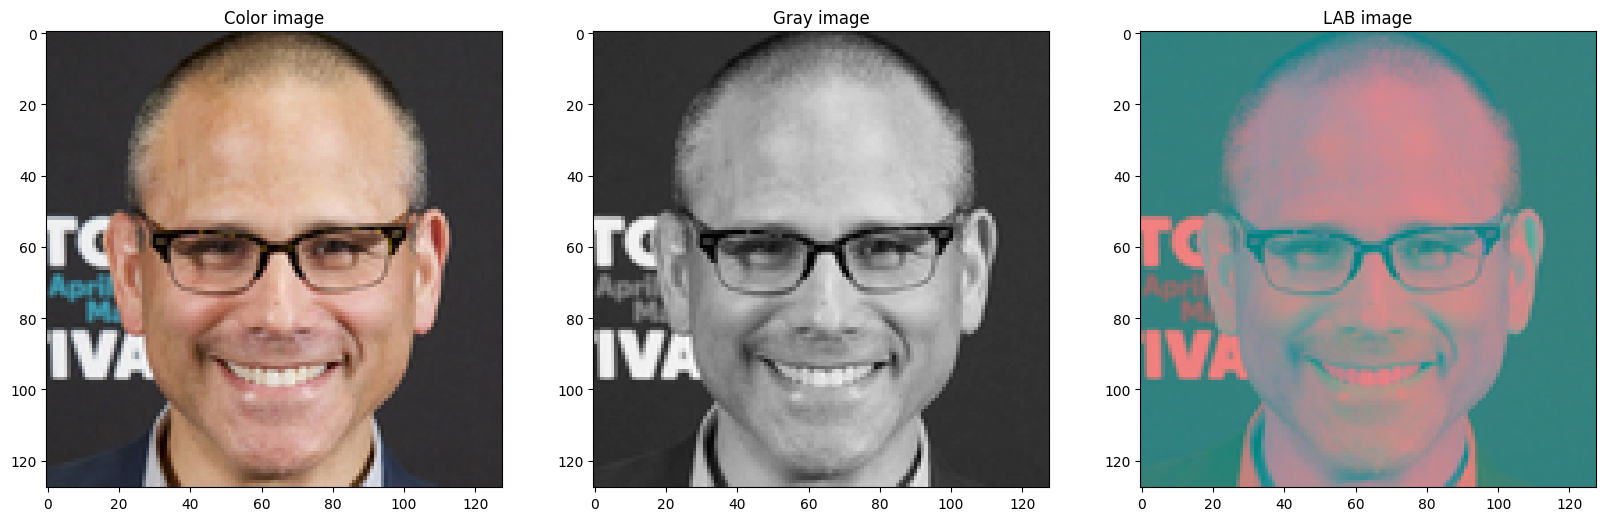

In [16]:
idx = np.random.randint(0, len(train_files_list))

img = cv2.imread(train_files_list[idx])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
print(np.shape(img))

plt.subplot(131), plt.imshow(img)
plt.title("Color image")
plt.subplot(132), plt.imshow(grey, cmap='gray')
plt.title("Gray image")
plt.subplot(133), plt.imshow(img_lab)
plt.title("LAB image")

print(img.shape)

### Create data generator and methods for checking models

In [17]:
from sklearn.utils import shuffle


class Generator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths

    def __len__(self):
        return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to **batch** index."""
        i = idx * self.batch_size
        batch_img_paths = self.input_img_paths[i: i + self.batch_size]

        x_batch = []
        y_batch = []

        for path in batch_img_paths:
            src_img = cv2.imread(path)
            src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

            img_lab = cv2.cvtColor(src_img, cv2.COLOR_RGB2Lab)
            img_lab = img_lab/255.0
            # resize image to network input size
            img_lab_rs = cv2.resize(img_lab, (input_size, input_size))
            x_img = img_lab_rs[:, :, 0]  # pull out L channel
            x_img = np.expand_dims(x_img, axis=2)
            y_img = img_lab_rs[:, :, 1:]  # Extracting the ab channel

            x_batch.append(x_img)
            y_batch.append(y_img)

        return np.array(x_batch), np.array(y_batch)


    def on_epoch_end(self):
        self.input_img_paths = shuffle(self.input_img_paths)

In [18]:
def plot_history(history, metric):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h[metric], '.-',
                               epochs, h['val_'+metric], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel(metric)
    plt.legend(['Train', 'Validation'])
        
    print('Train     ', h[metric][-1])
    print('Validation', h['val_'+metric][-1])

In [19]:
def ShowResult(model):
    idx = np.random.randint(0, len(test_files_list))

    src_img = cv2.imread(test_files_list[idx])
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    img_lab = cv2.cvtColor(src_img, cv2.COLOR_RGB2Lab)
    img_lab = img_lab/255.0
    img_lab_rs = cv2.resize(img_lab, (input_size, input_size)) # resize image to network input size
    gray = img_lab_rs[:,:,0] # pull out L channel

    output = model.predict(np.expand_dims(gray, axis=0))

    # gathering image chanels
    new_img = np.zeros((input_size, input_size, 3))
    new_img[:,:,0] = gray
    new_img[:,:,1:] = output[0]
    new_img = 255*new_img
    new_img = new_img.astype(np.uint8)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_Lab2RGB)

    #lab to rgb
    y_img = img_lab_rs[:,:,1:]
    lab_img = np.zeros((input_size, input_size, 3))
    lab_img[:,:,0] = gray
    lab_img[:,:,1:] = y_img
    lab_img = 255*lab_img
    lab_img = lab_img.astype(np.uint8)
    rgb_img = cv2.cvtColor(lab_img, cv2.COLOR_Lab2RGB)


    plt.subplot(131), plt.imshow(gray*255, cmap='gray')
    plt.title("Gray image")
    plt.axis('off')
    plt.subplot(132), plt.imshow(new_img)
    plt.title("Predicted image") 
    plt.axis('off')
    plt.subplot(133), plt.imshow(rgb_img)
    plt.title("Ground truth")
    plt.axis('off')

### Simple model (baseline)

In [20]:
def get_Alpha_model(input_size):
    inputs = layers.Input(shape=(input_size, input_size, 1))

    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(inputs)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    outputs = layers.Conv2D(2, (3, 3), activation='sigmoid', padding='same')(x)
    
    model = Model(inputs, outputs)
    return model

A_model = get_Alpha_model(input_size)
A_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 8)         584       
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 32)        9248  

In [21]:
# Data generators
train_gen = Generator(batch_size, img_size, train_files_list)
val_gen = Generator(batch_size, img_size, test_files_list)

A_model.compile(optimizer='rmsprop', loss='mse', metrics=["accuracy"])
history = A_model.fit(train_gen, epochs=20, validation_data=val_gen)

Epoch 1/20
4250/4250 [==============================] - 92s 21ms/step - loss: 0.0025 - accuracy: 0.5572 - val_loss: 0.0024 - val_accuracy: 0.5774
Epoch 2/20
4250/4250 [==============================] - 65s 15ms/step - loss: 0.0024 - accuracy: 0.5696 - val_loss: 0.0024 - val_accuracy: 0.5758
Epoch 3/20
4250/4250 [==============================] - 65s 15ms/step - loss: 0.0024 - accuracy: 0.5717 - val_loss: 0.0023 - val_accuracy: 0.5791
Epoch 4/20
4250/4250 [==============================] - 65s 15ms/step - loss: 0.0024 - accuracy: 0.5736 - val_loss: 0.0023 - val_accuracy: 0.5808
Epoch 5/20
4250/4250 [==============================] - 64s 15ms/step - loss: 0.0024 - accuracy: 0.5746 - val_loss: 0.0023 - val_accuracy: 0.5800
Epoch 6/20
4250/4250 [==============================] - 66s 15ms/step - loss: 0.0024 - accuracy: 0.5759 - val_loss: 0.0023 - val_accuracy: 0.5786
Epoch 7/20
4250/4250 [==============================] - 64s 15ms/step - loss: 0.0024 - accuracy: 0.5775 - val_loss: 0.0023 -

Train      0.5853242874145508
Validation 0.5952343940734863


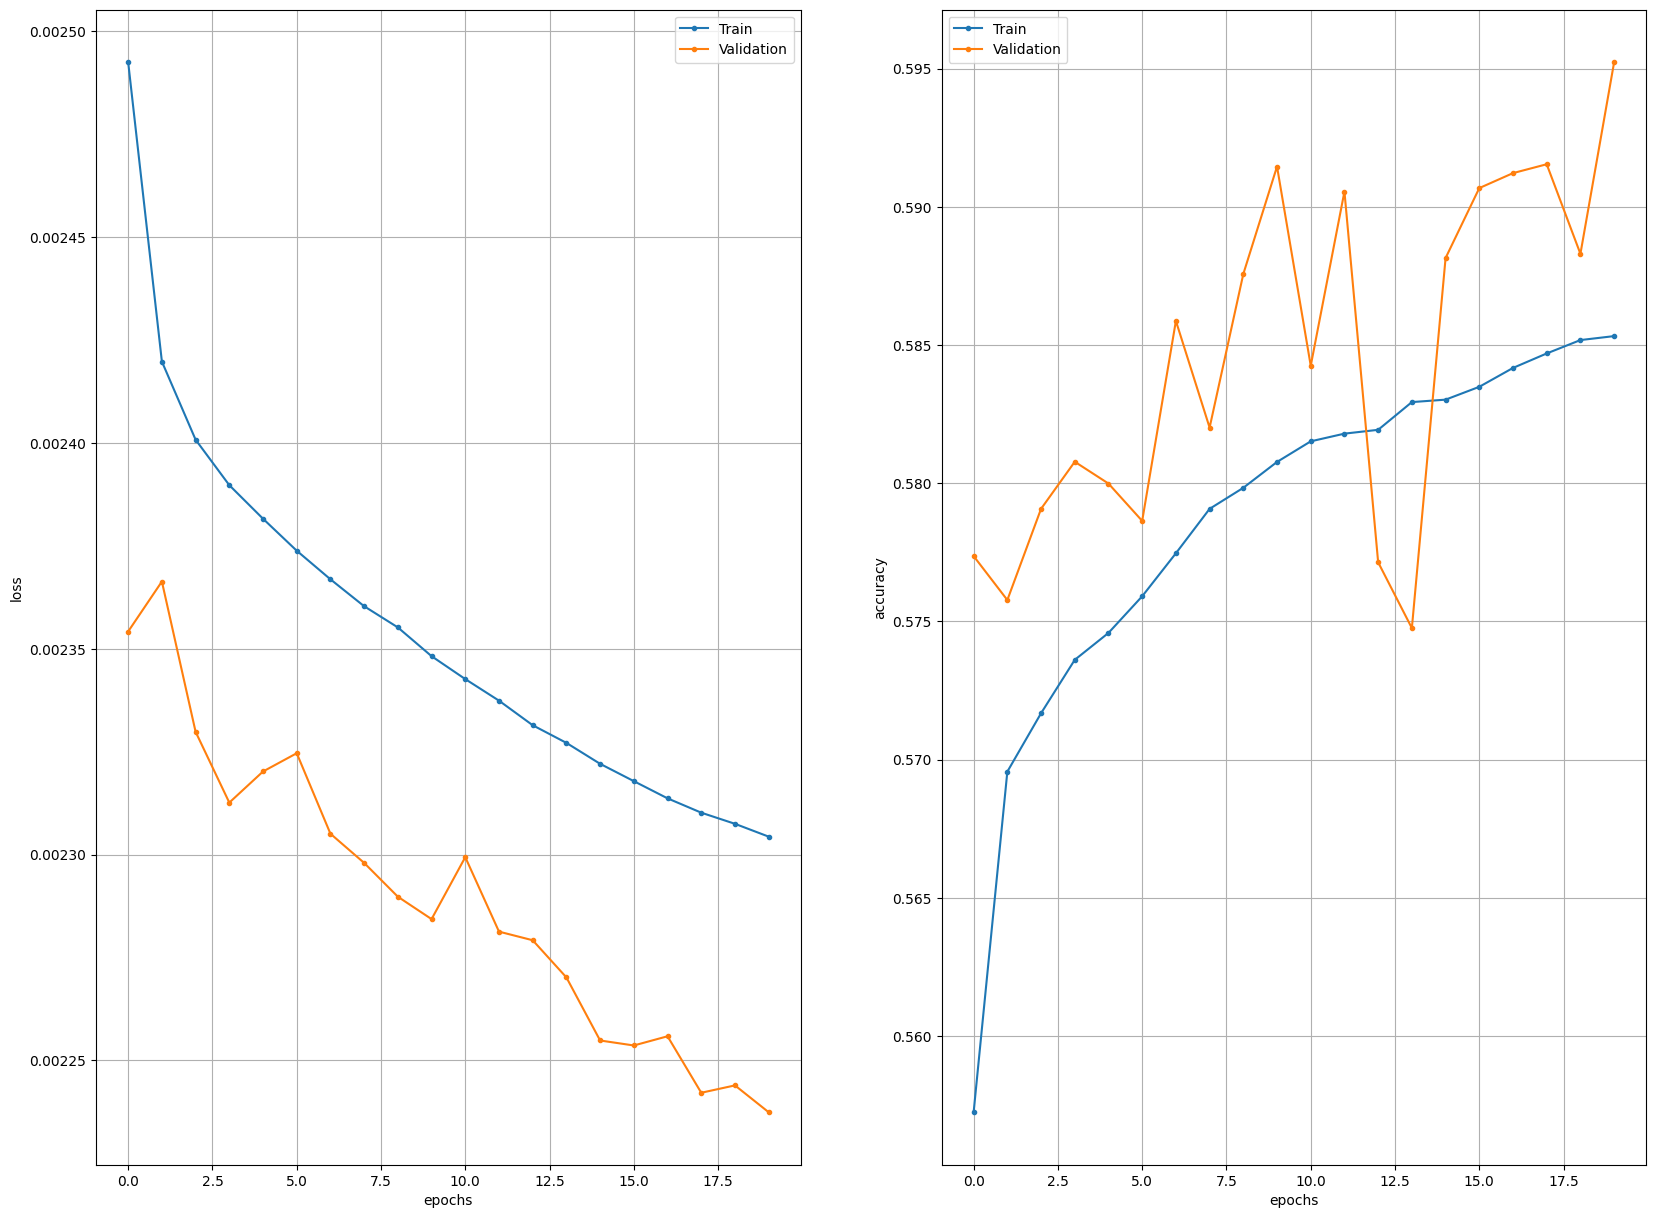

In [22]:
plot_history(history, 'accuracy')

1/1 [==============================] - 0s 252ms/step


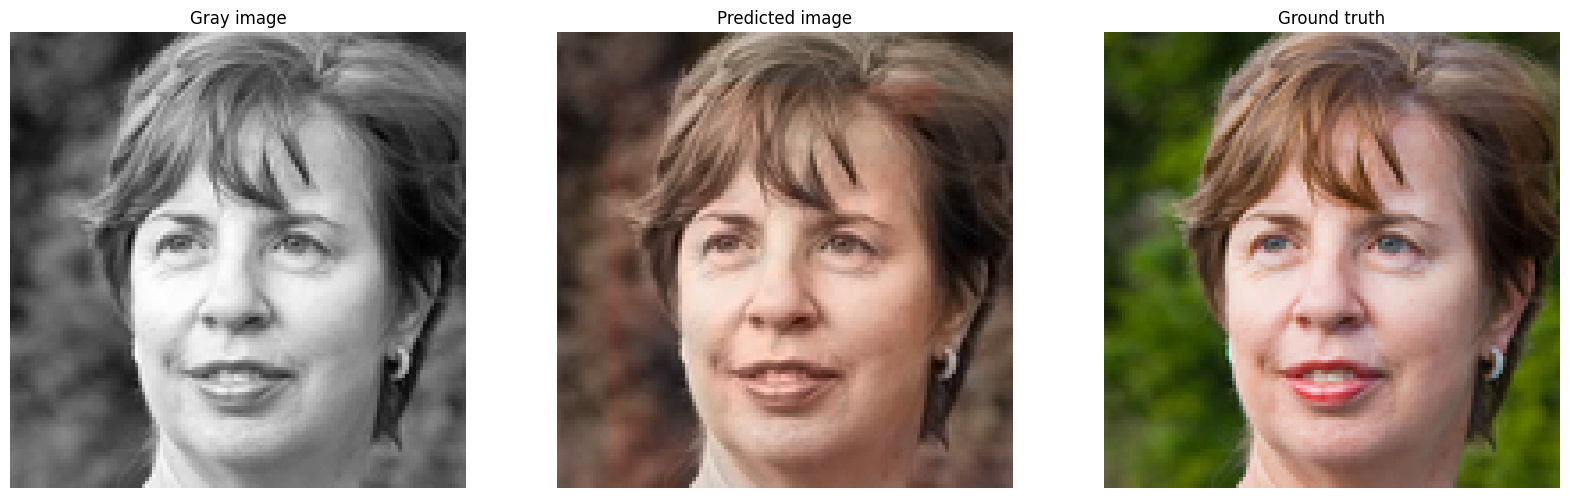

In [23]:
ShowResult(A_model)

### U-net model

In [25]:
def get_U_model(input_size):
    inputs = layers.Input(shape=(input_size, input_size, 1))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    # x = layers.LeakyReLU()(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add output layer with sigmoid activation function (result between 0 and 1)
    outputs = layers.Conv2D(2, 3, activation='sigmoid', padding='same')(x)

    # Define the model
    model = Model(inputs, outputs)
    return model


In [26]:
model = get_U_model(input_size)
model.summary()
# plot_model(model, show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 64, 64, 32)   320         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d_9[0][0]']               
 alization)                                                                                       
                                                                                            

                                                                                                  
 activation_8 (Activation)      (None, 8, 8, 256)    0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 8, 8, 256)   590080      ['activation_8[0][0]']           
 spose)                                                                                           
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 8, 8, 256)   1024        ['conv2d_transpose_1[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 up_sampling2d_4 (UpSampling2D)  (None, 16, 16, 256)  0          ['add_2[0][0]']                  
          

                                                                                                  
 up_sampling2d_10 (UpSampling2D  (None, 128, 128, 64  0          ['add_5[0][0]']                  
 )                              )                                                                 
                                                                                                  
 up_sampling2d_9 (UpSampling2D)  (None, 128, 128, 32  0          ['batch_normalization_14[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 128, 128, 32  2080        ['up_sampling2d_10[0][0]']       
                                )                                                                 
                                                                                                  
 add_6 (Ad

In [27]:
# Peak Signal to Noise Ratio function
def psnr(orig, pred):
    # cast the target images to integer
    orig = orig * 255.0
    orig = tf.cast(orig, tf.uint8)
    orig = tf.clip_by_value(orig, 0, 255)
    # cast the predicted images to integer
    pred = pred * 255.0
    pred = tf.cast(pred, tf.uint8)
    pred = tf.clip_by_value(pred, 0, 255)
    # return the psnr
    return tf.image.psnr(orig, pred, max_val=255)

In [28]:
# configure early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min', restore_best_weights=True)

# Data generators
train_gen = Generator(batch_size, img_size, train_files_list)
val_gen = Generator(batch_size, img_size, test_files_list)

In [29]:
epochs = 20

# compile the model
model.compile(loss='mse', optimizer='adam', metrics=psnr)

# train
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=[early_stopping])

Epoch 1/20
4250/4250 [==============================] - 204s 46ms/step - loss: 0.0035 - psnr: 27.2796 - val_loss: 0.0023 - val_psnr: 27.8505
Epoch 2/20
4250/4250 [==============================] - 198s 47ms/step - loss: 0.0023 - psnr: 27.8683 - val_loss: 0.0022 - val_psnr: 28.0314
Epoch 3/20
4250/4250 [==============================] - 192s 45ms/step - loss: 0.0022 - psnr: 28.0481 - val_loss: 0.0022 - val_psnr: 28.1779
Epoch 4/20
4250/4250 [==============================] - 187s 44ms/step - loss: 0.0021 - psnr: 28.2002 - val_loss: 0.0021 - val_psnr: 28.1590
Epoch 5/20
4250/4250 [==============================] - 187s 44ms/step - loss: 0.0021 - psnr: 28.2979 - val_loss: 0.0021 - val_psnr: 28.3029
Epoch 6/20
4250/4250 [==============================] - 186s 44ms/step - loss: 0.0021 - psnr: 28.3808 - val_loss: 0.0021 - val_psnr: 28.3316
Epoch 7/20
4250/4250 [==============================] - 188s 44ms/step - loss: 0.0020 - psnr: 28.4519 - val_loss: 0.0023 - val_psnr: 27.7708
Epoch 8/20
42

Train      29.525251388549805
Validation 28.067136764526367


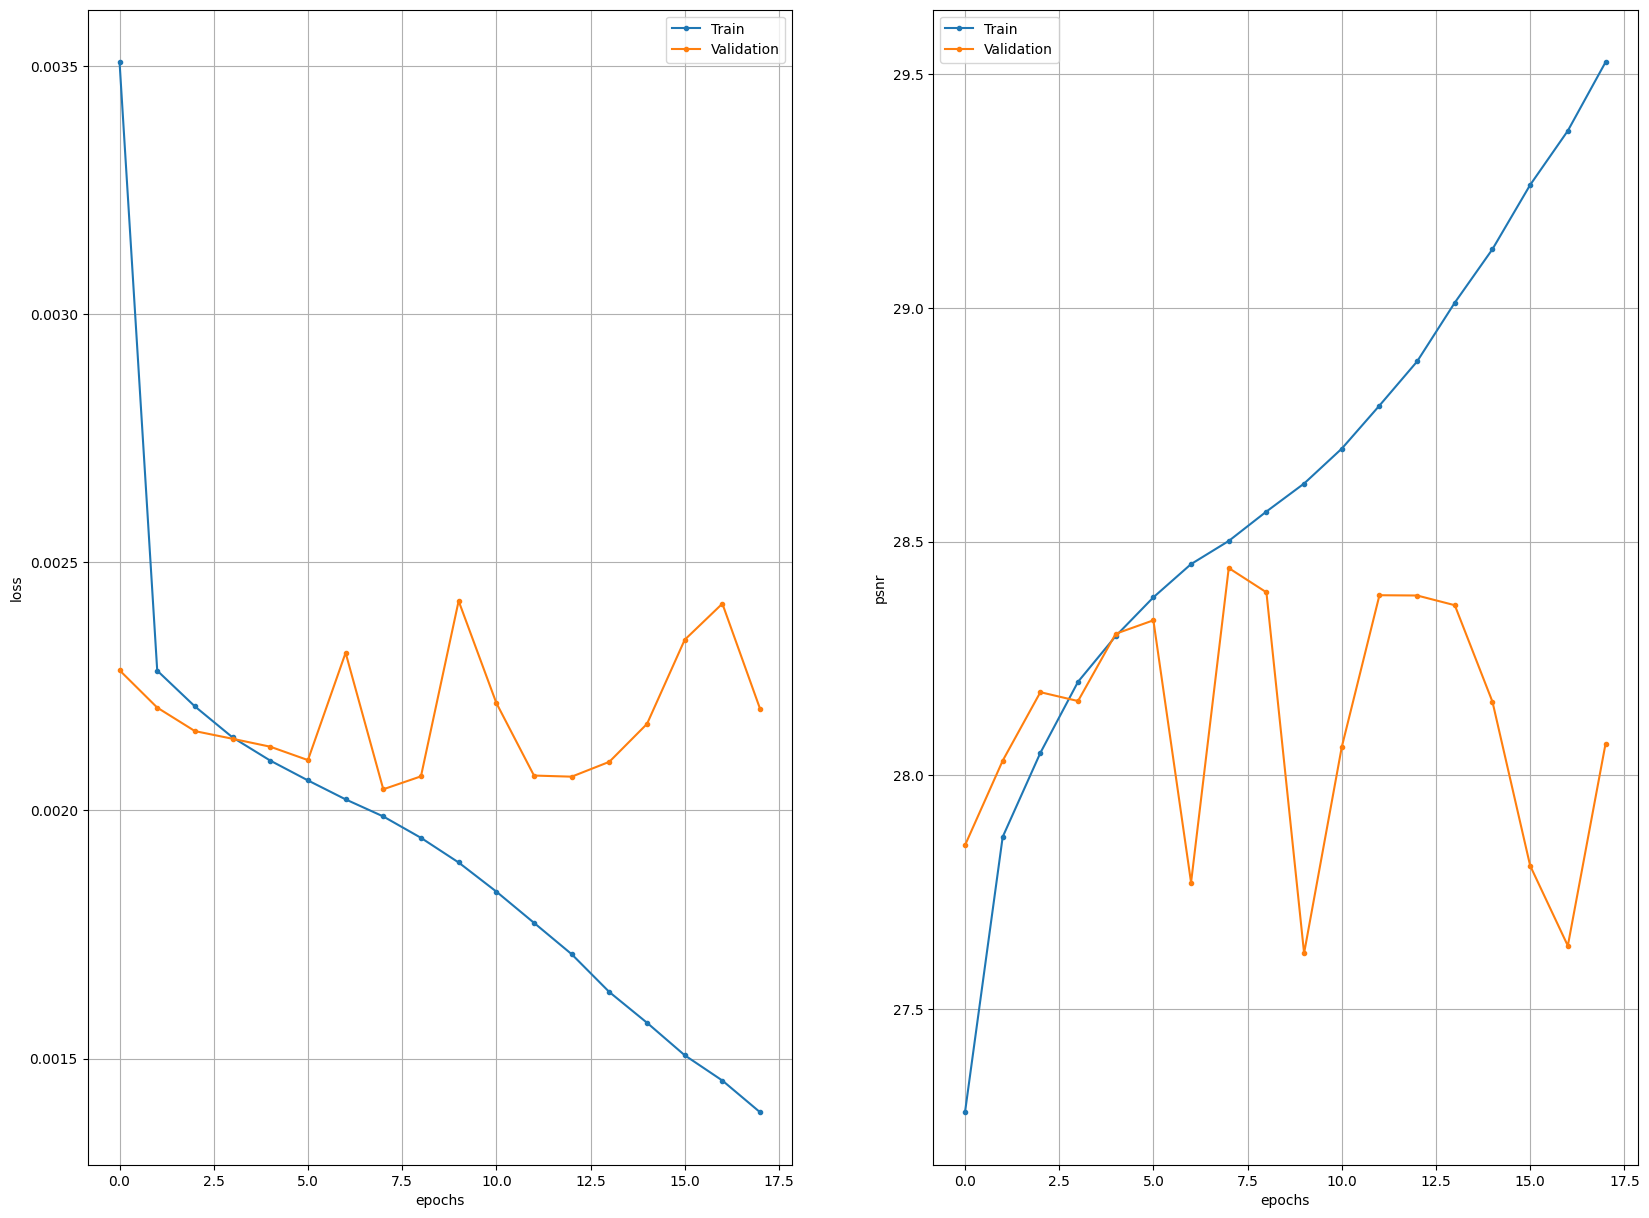

In [30]:
plot_history(history, 'psnr')

1/1 [==============================] - 0s 24ms/step


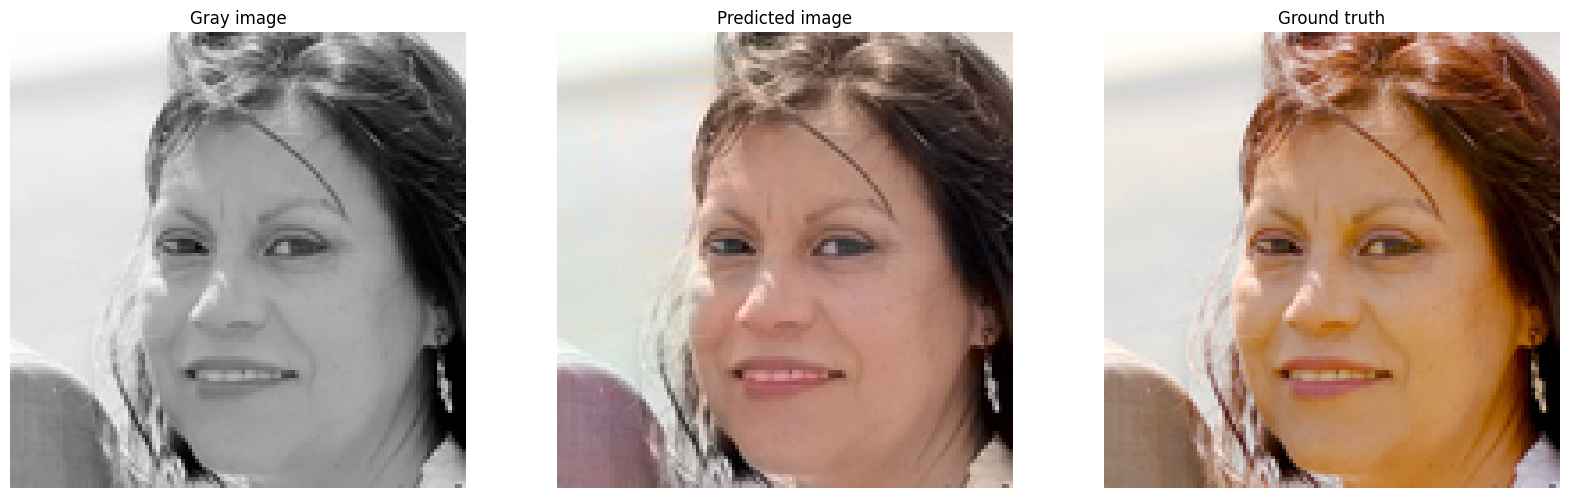

In [36]:
ShowResult(model)

In [34]:
model.save('colorizer_model')

INFO:tensorflow:Assets written to: colorizer_model/assets


INFO:tensorflow:Assets written to: colorizer_model/assets
